In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle

## Using the pretrained models

In [ ]:
marker = 'Ki67'
mode = 'combat'


In [ ]:
csv_list = []
for file in os.listdir(f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/downstream/non-spatial/thresholding/{mode}_test'):
    if file.endswith('.csv'):
        csv = pd.read_csv(os.path.join(f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/downstream/non-spatial/thresholding/{mode}_test', file), index_col=0)
        csv_list.append(csv)
df = pd.concat(csv_list)
loaded_encoders = {}
for name in ['cellcharter', 'phenotype3', 'disease2']:
    with open(f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/downstream/non-spatial/thresholding/encoders/{name}_encoder.pkl', 'rb') as f:
        loaded_encoders[name] = pickle.load(f)
#df['cellcharter_CN'] = loaded_encoders['cellcharter'].transform(df['cellcharter_CN'])
#df['Phenotype3'] = loaded_encoders['phenotype3'].transform(df['Phenotype3'])
df['disease2'] = loaded_encoders['disease2'].transform(df['disease2'])
if mode == 'scanorama':
    df.drop(columns=['distance_to_bone', 'X_centroid', 'Y_centroid', 'Phenotype', 'Phenotype2', 'disease', 'image_ID', 'patient_ID', 'Object', 'ROI', ' 1', ' 2', ' 3', ' 4', ' 5', ' 6', 'HistoneH3', '191Ir', '193Ir'], inplace=True)
else:
    df.drop(columns=['distance_to_bone', 'X_centroid', 'Y_centroid', 'Phenotype', 'Phenotype2', 'disease', 'image_ID', 'patient_ID', 'Object', 'ROI'], inplace=True)
df.drop(columns=[x for x in df.columns if 'counts' in x and x != f'{marker}_counts'], inplace=True)

In [119]:
model = XGBClassifier()
model.load_model(f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/downstream/non-spatial/thresholding/xgb_models/xgb_{mode}_{marker}.json')
y_test = np.array(df[f'{marker}_counts'])
df.drop(columns=[f'{marker}_counts'], inplace=True)
pred = model.predict(df)

In [120]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     20714
           1       0.76      0.93      0.84      5676

    accuracy                           0.92     26390
   macro avg       0.87      0.92      0.89     26390
weighted avg       0.93      0.92      0.92     26390



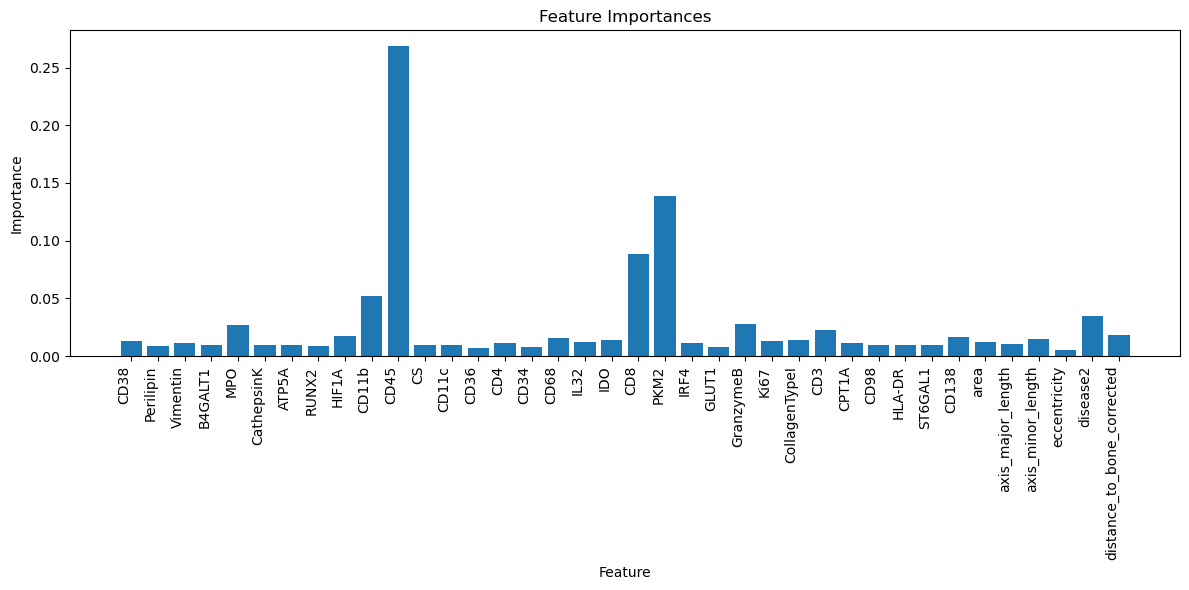

In [121]:
importances = model.feature_importances_
features = df.columns

plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances, tick_label=features)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [23]:
confusion_matrix(y_test, pred)

array([[25998,    19],
       [  168,   205]])